# **Tutorial** : Which cartographic representation for a point data set ? 
## Overview of some existing techniques using CartAGen
Press **`space bar`** to show next slide 

- 🙋 **For whom ?** : 
  - people who have spatial data to enhance through maps, but don't know which cartographic representation to choose
  - expert cartographers wishing to discover the **possibilities of cartographic generalization** offered by the CartAGen tool
  - anyone wishing to learn about the various problems encountered when creating maps from point data (and how to get around these problems).

Press **`space bar`** and **`scroll down`** to show next message 


- ❓ **What is CartAGen ?** :
    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment  
    
Press **`space bar`** and **`scroll down`** to show next message 


- 📗 **How to use this Notebook ?** : 
    - a Notebook is a document that mixes **markdown cells** (i.e. cells with formatted text like this one) and **code cells**, which you can modify and execute at will
    - it comes with a **sample data set** on which you can **test** the various features of the CartAGen python library
    - you can import your **own data** and run the code cells of this Notebook, or use the CartAGen tool in **another environment** (QGIS or python script)

Press **`right arrow`** to show next slide and start part 0, or press **`space bar`** to show sub-slide and see useful links

   
- 🔗 **Useful links** : 
    - [Library repository](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file) 
    - [QGIS Plugin repository](https://github.com/LostInZoom/cartagen-qgis)
    - [CartAGen documentation](https://cartagen4py.readthedocs.io/en/latest/index.html)

_by Paul Bourcier, 2024 - EUPL 1.2_

Press **`space bar`** to show next slide, press **`shift + space bar`** to go backward\
**`Click`** question mark icon to show other shortcuts

## ⚙️ **Part 0 :** Preparing the working environment

Press **`space bar`** to show code cell, then press **`shift + enter`** to execute it\
**`*`** symbol means code output is loading

In [2]:
# Importing libraries

from matplotlib import pyplot as plt # for ploting results, especially maps
import cartagen as cg # the main library, containing cartographic generalization algorithms
import geopandas as gp # used to import and manipulate geographic data
import pandas as pd # used to concatenate datas
import ipywidgets # creation of interactive plots
import os # navigation within the environnement
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
import matplotlib.colors as matcol # generating color palettes
from matplotlib.path import Path  # Plot generation
from matplotlib.patches import PathPatch # Plot generation
from matplotlib.figure import Figure # Plot generation
from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
from shapely.geometry import Polygon, MultiPolygon, Point # Create and manipulate geometries
from shapely.wkt import loads # Create and manipulate geometries
from shapely import intersects
from shapely.ops import linemerge, transform
from tqdm.notebook import tqdm # Creating loading bar
from time import sleep # Creating loading bar
import numpy as np # Using mathematical operations in Python
import re # regex
from IPython.display import clear_output, Image # used to delete widgets
import pydeck as pdk #pydeck for interactive maps
import json #manipulating dictionnaries
import contextily as ctx # Adding basemaps
import random #generating random numbers
import matplotlib.colors as mcolors #generating colors 
import matplotlib.cm as cm #used to display colorbar
# from matplotlib.path import Path
# from matplotlib.patches import PathPatch
import progressbar
import mapclassify #choroplete map settings
from sklearn import cluster #clustering methods
import ipyleaflet #creates interactive maps

import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*GeoDataFrame you are attempting to plot is empty.*") # Remove user warning 
warnings.filterwarnings("ignore", category=UserWarning, message=".*CRS not set for some of the concatenation inputs.*.")
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning, message=".*A value is trying to be set on a copy of a slice from a DataFrame.*.")

## ❌ **Part 1 :** Common issues with point data representation

Nowadays, more and more spatial data set shared by data producers take form of point data set, i.e datas associated with x/y coordinate enabling their integration in maps. Those point data sets concern a wide variety of thematic : environnement, population, urbanism, mobilities, etc. 

Let's figure out some issues when cartographying these kind of data.

### **1.1/** Why displaying raw point data set can induce limitations ?

When creating maps with the purpose of showing the spatial distribution of a phenomenon, displaying every individual point of our dataset can be problematic. Let's take the example of the restaurant selling crepes in Brittany, France : 

**1.1.1/** Displaying maps of creperies in Brittany

💬 This Notebook is meant to be interactive (beyond code modifications) : after **running** a code cell, you will often be able to **change** algorithm parameters or figure settings, thanks to **buttons**. Let's try changing the figure size thanks to a slider button.

In [2]:
#Displaying maps of crepe restaurants in Brittany
brittany = gp.read_file('data/puntos/brittany.geojson')
crepes = gp.read_file('data/puntos/crepes.geojson')
widgets = [
    '', progressbar.Percentage(), ' ',  
    progressbar.Bar(marker='🟩', left='', right='                                                  ', width = 1) 
]

def plt_bre_1(figure_size):
    
    with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
        ax = brittany.plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (figure_size,figure_size))
        bar.update(1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        scalebar = AnchoredSizeBar(ax.transData,
                                10000,  
                                '10 km',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        crepes.plot(ax=ax)    
        bar.update(2)
    
ipywidgets.interact(plt_bre_1, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=12, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.plt_bre_1(figure_size)>

💬 This map shows all the creperies in Brittany that are represented in the [OSM](https://www.openstreetmap.org/#map=14/48.81620/-1.17910) database. Because some points are overlaping eachother, it is difficult to read the spatial distribution of these restaurants. Eventhough we understand that there are more restaurants in the mains cities and in some part of the coast, we can't really say if there are more restaurants in Rennes or Brest, for example. 

💬 Let's try to lower the opacity of the points, so we can see more easily when several points are overlaping 

**1.1.2/** Displaying creperies with opacity

In [3]:
#Trying to lower the opacity to see if spatial distribution are more readable

def plt_bre_1(figure_size, opacity):
    with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
        ax = brittany.plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (figure_size,figure_size))
        bar.update(1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        scalebar = AnchoredSizeBar(ax.transData,
                                10000,  
                                '10 km',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        crepes.plot(ax=ax, alpha = opacity)
        bar.update(2)
ipywidgets.interact(plt_bre_1, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                               opacity = ipywidgets.FloatSlider(value =0.7, min = 0, max = 1,step = 0.01,continuous_update=False))



interactive(children=(IntSlider(value=12, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.plt_bre_1(figure_size, opacity)>

With this technique, spatial distribution is getting clearer. But it is still not enough to determine in which city there are more creperies ! We will see some techniques to improve the readibility of the map regarding the spatial distribution of those restaurants in part 2... 

### **1.2/** Point data sets in multi-scale maps : the persistant problem of scale

Nowadays, geographic data sets are often displayed on interactive maps, i.e maps in which the user can change the current view by zooming or panning. When it comes to point data sets, it is true that this medium offers the possibility to look precisly where the points are located within a desired zone. However, displaying raw data point still generate map readability problems at certain scales.

Let's take the example of parking meters in Paris :

**1.2.1/** Interactive map of parking meters in Paris

💬 Once the interactive map is loaded, you can navigate through it just like in other websites !

In [3]:
horo = gp.read_file('data/puntos/horodateurs-mobiliers.geojson')

for i in range(len(horo)):
    horo.loc[i,'lon'] = json.loads(horo.loc[i,'geo_point_2d'])['lon']
    horo.loc[i,'lat'] = json.loads(horo.loc[i,'geo_point_2d'])['lat']

mean_latitude = horo.lat.mean()
mean_longitude = horo.lon.mean()
df = horo.drop(columns='geometry')

layer = pdk.Layer(
    "ScatterplotLayer",
    df,
    opacity=0.8,
    stroked=True,
    filled=True,
    radius_scale=6,
    radius_min_pixels=5,
    radius_max_pixels=100,
    line_width_min_pixels=0,
    get_position=["lon", "lat"],
    pickable=True,
)

view_state = pdk.ViewState(longitude=mean_longitude, latitude=mean_latitude, zoom=15, bearing=0, pitch=0)

r = pdk.Deck(layers=[layer],initial_view_state=view_state, map_provider="carto",  map_style="light_no_labels", tooltip={"text": "{numhoro}"})

r.to_html('ScatterplotLayer.html')

This example highlights one fact : when the zoom level is high, displaying every point of our data set is a good idea since we easily understand where is each parking meters (which can be useful to find one in a real context). 

However, when the zoom level is low (for example when it is possible to see Paris as a whole), the map is saturated of information, raw point representation not being optimized in that case.

In fact, the problem the problem of showing all points at low zoom levels is not only that map is saturated with points, but also that map reader needs most likely change. 

Indeed, when looking at whole Paris, the need of the map reader is probably not to find the parking meters next to him, but most likely to understand how this equipment is distributed in the city (without understanding the precise location of each of them).

To conclude on this part, interactive maps don't solve the problem of cartographic representation of the datas. In other words, there are still needs for transforming it at certain scales, to make the map more readable. 

Those transforming operations are called cartographic generalization. CartAGen proposes some tools to perform generalization.

## 🛠 **Part 2 :** Exploring cartographic generalization techniques with CartAGen
As we saw, scale is what matter when defining which cartographic representation to choose. Let's explore generalization techniques according to it.

### **2.1/** Point displacement techniques
At large scale (i.e small zones, high zoom level...), we generally want to keep each point in our representation, to be as close as reality. When points start to overlap eachother, point displacement algorithms can be useful, since they make the map more readable but also keep the number of points on the map.

**2.1.1/** Display the points to displace

In [ ]:
# Display points to displace
admin = gp.read_file('data/puntos/arr_paris.geojson')
admin.to_crs(crs="EPSG:3857",inplace=True)
horo.to_crs(crs="EPSG:3857",inplace=True)
horo_ok = gp.clip(horo, admin.loc[14:15])

with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
    ax = admin.loc[14:15].plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (9,9))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    scalebar = AnchoredSizeBar(ax.transData,
                            1000,  
                            '1000 m',  
                            'lower left',  
                            pad=0.5,
                            color='black',
                            frameon=True,
                            size_vertical=1)
    ax.add_artist(scalebar)

    horo_ok.plot(ax=ax)
    bar.update(1)
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
    bar.update(2)

Yet, there is no algorithm dedicated to point displacement in CartAGen. Nonetheless, it is possible to use the random_displacement algorithm by transforming our points into polygons before : 

**2.1.2/** Converting points to polygons by creating buffers

In [ ]:
# Converting points to polygons by creating buffers
horo_poly = horo_ok.copy()

with progressbar.ProgressBar(max_value=len(horo_poly),widgets=widgets) as bar:
    count = 0
    for index, pt in horo_poly.iterrows():
        horo_poly.loc[index,'geometry'] = horo_poly.loc[index,'geometry'].buffer(42)
        count += 1
        bar.update(count)
if horo_poly.geometry.geom_type.unique()[0] == 'Polygon':
    print("✅ successful transformation")
else:
    print("❌ transformation failed")

**2.1.3/** Displacing points using the random_displacement algorithm

💬 Here, the "max trials" parameter is set to one, which means that each feature overlaping (or being to close to) another one is displaced one time. 

If this parameter is set to two, the algorithm will perform the displacement twice (most likely in two different directions since it is chosen randomly) and keep the situation that have the less overlaps. 

Setting a high value for this parameter will highly extend computation time (up to several minutes).

In [ ]:
# Displacing point buffers
widgets1 = [
    '', progressbar.Percentage(), ' ',  
    progressbar.Bar(marker='🟩', left='', right='                        '), ' (', progressbar.ETA(), ') ' 
]
def disp_pts(polygon_distance, max_trials, max_displacement):
    global horo_poly
    with progressbar.ProgressBar(max_value=4,widgets=widgets1) as bar:
        bar.update(1)
        horo_poly = cg.random_displacement(horo_poly, polygon_distance=polygon_distance, max_trials=max_trials, max_displacement=max_displacement)
        bar.update(2)

        fig, axs = plt.subplots(1, 2, figsize = (14,14))

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(np.asarray(horo_ok.geometry.get_coordinates())[:,:1], np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(3)
        axs[0].set_xlim(left=254968, right=259800)
        axs[0].set_ylim(bottom=6248519, top=6255324)
        axs[0].set_aspect('equal')
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)

        axs[1].set_title('After', pad=10, family='sans-serif')
        axs[1].scatter(np.asarray(horo_poly.geometry.centroid.get_coordinates())[:,:1], np.asarray(horo_poly.geometry.centroid.get_coordinates())[:,-1])
        bar.update(4)
        axs[1].set_xlim(left=254968, right=259800)
        axs[1].set_ylim(bottom=6248519, top=6255324)
        axs[1].set_aspect('equal')
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
   

ipywidgets.interact(disp_pts, polygon_distance = ipywidgets.BoundedIntText(value=10, min=0, max=200, step=1,description='polygon distance',style={'description_width': 'initial'}),
                              max_trials = ipywidgets.BoundedIntText(value=1, min=0, max=200, step=1,description='max trials'),
                              max_displacement = ipywidgets.BoundedIntText(value=10, min=0, max=200, step=1,description='max displacement', style={'description_width': 'initial'}))

Setting a low "max_trials" parameter reduce the computation time but the resulting displacement is often not satisfactory. A "max_trials" value of 25 is better in our case (but computation time is long).

**2.1.3'/** Code details on random_displacement algorithm

In [ ]:
pm_polygons = horo_ok.copy() # copying the points to displace
pm_polygons.geometry = pm_polygons.geometry.buffer(42) #changing point geometry to polygon geometry with 42 meters buffer 

pm_polygons = cg.random_displacement(pm_polygons, polygon_distance=20,
                                                  max_trials=1, 
                                                  max_displacement=10)
                                     #displacing polygons /!\ can be long if max_trials is high

pm_polygons.geometry = pm_polygons.geometry.centroid 
pm_polygons.plot(figsize=(9,9)) #after displacement
horo_ok.plot(figsize=(9,9)) #before displacement

### **2.2/** Point reduction techniques
As the scale decreazes, more and more points overlaps eachother, so that displacement become less easy to perform. At this point, having all the points on the map become less important : the map is more about having a global vision of the spatial distribution of the datas. Point reductions algorithms enable these transformations.

**2.2.1/** Using reduce_kmeans algorithm

In [ ]:
# Reduce_points_kmeans algorithm
horo_ok = gp.clip(horo, admin.loc[13:16])

def kmean(figure_size, shrink_ratio):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        horo_red = cg.reduce_kmeans(horo_ok,ratio=shrink_ratio,mode='simplification')
        bar.update(1)
        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')
        
        axs[1].set_title('After', pad=10, family='sans-serif')
           
        axs[1].scatter(np.asarray(horo_red.geometry.x), np.asarray(horo_red.geometry.y))
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_aspect('equal')
        
ipywidgets.interact(kmean, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                           shrink_ratio = ipywidgets.FloatSlider(value =0.7, min = 0, max = 1,step = 0.01,continuous_update=False))

The reduce point kmeans algorithm tends to uniformize the spatial distribution of the point data set by deleting more points in areas where the point density is higher. It can be a problem, because there is a risk that cartographic representation doesn't reflect real spatial distribution. Here is another algorithms to reduce the number of points : 

**2.2.1'/** Code details on reduce_kmeans algorithm

In [ ]:
horo_red = cg.reduce_kmeans(horo_ok,ratio=0.7,mode='simplification')

horo_red.plot(figsize=(9,9))

**2.2.2/** Using reduce_quadtree algorithm

In [ ]:
# reduce_points_quadtree algorithm (simplification mode)
horo_ok = gp.clip(horo, admin.loc[13:16])

def qtree_simp(figure_size, depth):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    # horo_red = cg.reduce_points_quadtree(horo_ok,5,mode='simplification')
    # horo_red = [x[0] for x in horo_red[0]]
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        horo_red = cg.reduce_quadtree(horo_ok,depth=depth,mode='simplification')
        bar.update(1)

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
     
        axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1])
            
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_xlim(left=253668, right=261883)
        axs[1].set_ylim(bottom=6248519, top=6258324)
        axs[1].set_aspect('equal')

ipywidgets.interact(qtree_simp, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                                depth = ipywidgets.IntSlider(value =5, min = 0, max = 8,step = 1,continuous_update=False))

The reduce point quadtree algorithm seems quicker in terms of processing time.
It has the disavantage that the reduction strenth can not be thinly set up.

Note that those algorithms delete points based on their position, without dealing with attributes. In others words, if you want to reduce point prior to setting up a symbology based on an attribute value, you should not use those algorithms. Here what you could do. 

**2.2.2'/** Code details on reduce_quadtree algorithm

In [ ]:
reduced = cg.reduce_quadtree(horo_ok,depth=5,mode="simplification") #Using the reduce_quadtree function on a gdf contianing our points

reduced.plot(figsize=(9,9))

**2.2.3/** Adding a fake attribute to our datas

Let's say we add an attribute containing the number of places in the parking area. Calling it "nb_places"

In [ ]:
# Adding a fake value to parking meters points (let's say the number of places in the parking area)
horo_value = horo.copy()
with progressbar.ProgressBar(max_value=len(horo_value),widgets=widgets) as bar:
    for i in range(len(horo_value)):
        horo_value.loc[i,'nb_places'] = random.randint(1, 100) 
        bar.update(i)
#create a field based on index for merging df later
horo_value['index'] = horo_value.index
print("Sample of our data containing the 'nb_places' attribute : ")
horo_value[['nb_places','index','numhoro']].head(2)

**2.2.4/** Using reduce_quadtree algorithm with an attribute value ("selection mode")

"selection" mode will retains the point with the largest value in the chosen column, weighted by the depth of the point.

In [ ]:
# reduce_quadtree algorithm (selection mode)
horo_value_clp = gp.clip(horo_value, admin.loc[13:16])

def qtree_attr(figure_size, depth, display_sizes):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        horo_red = cg.reduce_quadtree(horo_value_clp,depth=depth,mode="selection",column='nb_places')
        bar.update(1)

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
        
        if display_sizes == True:
            axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1], s= horo_red['nb_places'])
        else:   
            axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1]) 
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_xlim(left=253668, right=261883)
        axs[1].set_ylim(bottom=6248519, top=6258324)
        axs[1].set_aspect('equal')

ipywidgets.interact(qtree_attr, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                                depth = ipywidgets.IntSlider(value =5, min = 0, max = 8,step = 1,continuous_update=False),
                                display_sizes = False
                                )

In this case, for each group of points in which the algorithm deletes points, the point with the highest value is kept. However, reduce_quadtree algorithm also tends to uniformize the spatial distribution. Note that selection mode also exists on reduce_kmeans algorithm.

**2.2.4'/** Code details on reduce_quadtree algorithm with selection mode 

In [ ]:
reduced = cg.reduce_quadtree(horo_value_clp,depth=5,mode="selection",column='nb_places')

reduced.plot(figsize=(9,9))

**2.2.5/** Using reduce_labelgrid algorithm with selection mode 

In [ ]:
# Using the LabelGrid algorithm with selection mode 
horo_value_clp = gp.clip(horo_value, admin.loc[13:16])
horo_value_clp.reset_index(inplace=True)
extent = horo_value_clp.total_bounds

def lb_selec(figure_size, shape, width, height, sizes, show_grid):
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        lg = cg.reduce_labelgrid(horo_value_clp, width = width, height = height, column="nb_places", shape=shape, mode='selection', grid=True)
        bar.update(1)

        fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

        axs[0].set_title('Before', pad=10, family='sans-serif')
        if sizes == True:
            axs[0].scatter(x=np.asarray(horo_value_clp.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value_clp.geometry.get_coordinates())[:,-1],s= horo_value_clp.nb_places)
        else:
            axs[0].scatter(x=np.asarray(horo_value_clp.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value_clp.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)	
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
        if show_grid == True:
            for i in range(len(lg[1])):
                poly = Path.make_compound_path(Path(np.asarray(lg[1].geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in lg[1].geometry[i].interiors])
                axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15, alpha= 0.7))

        if sizes == True:
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1], s=lg[0].nb_places)
        else:
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1])
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)
        axs[1].set_aspect('equal')

ipywidgets.interact(lb_selec, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                              shape = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =250, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =250, min = 0, max = 1000,step = 1,continuous_update=False),
                              sizes = False,
                              show_grid = False)

The Label Grid algorithm basically do the same, but seems to preserves more the spatial distribution of the points, since the reduction strentgh is the same everywhere (without taking in account point density)

**2.2.5'/** Code details on reduce_points_labelgrid algorithm with selection mode 

In [ ]:
reduced = cg.reduce_labelgrid(horo_value_clp, width = 500, height = 500,
                                              shape="square", 
                                              column="nb_places", mode='selection')

reduced.plot(figsize=(9,9))

### **2.3/** Agregation techniques
At one moment, it becomes useless to represent point data as points on map. Indeed, at smaller scales (at whole Brittany in our first example and at Paris scale in the second one), there are whether to much information to display, or to much overlaps between points. In cartography, there are several ways to tackle this problem. Agregation is one of those.

Agregation consists of "merging" the information of the points into broader spatial entities (generally a polygon). A common type of agregation is the one made with administrative (or statistical) units. Performing agregation in administrative units doesn't require to use CartAGen (only Geopandas is needed).

**2.3.1/** Perform agregation in administrative/statistical units

In [ ]:
# Agregating points into adminstrative units in Paris
def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom
mun = admin.copy()
mun.loc[:,'geometry'] = mun.loc[:,'geometry'].apply(multipolygon_to_polygon)
neigh = gp.read_file('data/puntos/quartier_paris.geojson')
neigh.to_crs(crs="EPSG:3857",inplace=True)
iris = gp.read_file('data/puntos/iris.geojson')
iris.to_crs(crs="EPSG:3857",inplace=True)
iris.loc[:,'geometry'] = iris.loc[:,'geometry'].apply(multipolygon_to_polygon) 

horo_enr = gp.sjoin(horo_value, mun)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","geometry"]]
horo_enr = gp.sjoin(horo_enr, neigh)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","n_sq_qu", "l_qu","geometry"]]
horo_enr = gp.sjoin(horo_enr, iris)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","n_sq_qu", "l_qu","code_iris","nom_iris", "geometry"]]
horo_enr['nb_pm'] = 1

def agr_admin(figure_size, unit, value, show_units):
    if unit == 'IRIS':
        unit = 'code_iris'
    elif unit == 'neighborhoods':
        unit = 'n_sq_qu'
    else:
        unit = 'ID'

    if value == 'sum of places':
        value = 'nb_places'
    else:
        value = 'nb_pm'

    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))
    with progressbar.ProgressBar(max_value=6,widgets=widgets) as bar:
        horo_agr = horo_enr.groupby([unit]).sum(['nb_pm'])
        bar.update(1)
        if unit == 'code_iris':
            unit_to_disp = iris.merge(right=horo_agr, how='left', on = 'code_iris')
        elif unit == 'n_sq_qu':
            unit_to_disp = neigh.merge(right=horo_agr, how='left', on = 'n_sq_qu')
        else:
            unit_to_disp = mun.merge(right=horo_agr, how='left', on = 'ID')
        bar.update(2)
        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1])
        bar.update(3)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(4)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')
        axs[0].set_xlim(left=249654, right=272000)
        axs[0].set_ylim(bottom=6243332, top=6258584)

        axs[1].set_title('After', pad=10, family='sans-serif')
        if value == 'nb_places':
            axs[1].scatter(np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,-1], s= unit_to_disp[value]*0.2)
        else:
            axs[1].scatter(np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,-1], s= unit_to_disp[value])
        if show_units == True:
            for i in range(len(unit_to_disp)):
                poly = Path.make_compound_path(Path(np.asarray(unit_to_disp.geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in unit_to_disp.geometry[i].interiors])
                axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15))
        bar.update(5)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(6)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_aspect('equal')
        axs[1].set_xlim(left=249654, right=272000)
        axs[1].set_ylim(bottom=6243332, top=6258584)

ipywidgets.interact(agr_admin, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                               unit = ipywidgets.Dropdown(options=['IRIS', 'neighborhoods', 'municipalities'], value='neighborhoods', description='Agregation units:',style = {'description_width': 'initial'}),
                               value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:',style = {'description_width': 'initial'}),
                               show_units = False)

Thus, you can represent datas agregated in polygonal units as circles. You can also represent directly those units, and set up their color according to the information they contain (instead of showing it through circle size). However, this require to calculates ratio indicators, since it is not recommanded to show stock values with colors.

**2.3.2/** Display agregated datas in choroplete map style

In [ ]:
# Creating ratio indicators to display agregated data in choroplete map style
mun.to_crs(crs="EPSG:2154",inplace=True)
mun['area'] = mun['geometry'].area/1000000 #square kilometers

neigh.to_crs(crs="EPSG:2154",inplace=True)
neigh['area'] = neigh['geometry'].area/1000000

iris.to_crs(crs="EPSG:2154",inplace=True)
iris['area'] = iris['geometry'].area/1000000

def agr_admin_choro(figure_size, unit, value, colors):
    fig = plt.figure(1, (figure_size, figure_size))

    if value == 'sum of places':
        value = 'nb_places'
    else:
        value = 'nb_pm'

    if unit == 'IRIS':
        unit = 'code_iris'
    elif unit == 'neighborhoods':
        unit = 'n_sq_qu'
    else:
        unit = 'ID'

    
    horo_agr = horo_enr.groupby([unit]).sum(['nb_pm'])
        
    if unit == 'code_iris':
        unit_to_disp = iris.merge(right=horo_agr, how='left', on = 'code_iris')
    elif unit == 'n_sq_qu':
        unit_to_disp = neigh.merge(right=horo_agr, how='left', on = 'n_sq_qu')
    else:
        unit_to_disp = mun.merge(right=horo_agr, how='left', on = 'ID')
    with progressbar.ProgressBar(max_value=len(unit_to_disp)*2,widgets=widgets) as bar:    
        for i in range(len(unit_to_disp)):
            unit_to_disp.loc[i,'density'] = unit_to_disp.loc[i,value]/unit_to_disp.loc[i,'area']
            bar.update(i)
        unit_to_disp = unit_to_disp.dropna()
        unit_to_disp = unit_to_disp.reset_index(drop = True)
        unit_to_disp.loc[:,'geometry'] = unit_to_disp.loc[:,'geometry'].apply(multipolygon_to_polygon) 
        unit_to_disp.to_crs(crs="EPSG:3857", inplace=True)

        sub1 = fig.add_subplot(121)
        sub1.set_title('Before', pad=10, family='sans-serif')
        sub1.scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1])
        ctx.add_basemap(sub1,source=ctx.providers.CartoDB.Positron)
        sub1.axes.get_xaxis().set_visible(False)
        sub1.axes.get_yaxis().set_visible(False)
        sub1.set_aspect('equal')
        sub1.set_xlim(left=249654, right=272000)
        sub1.set_ylim(bottom=6243332, top=6258584)

        sub2 = fig.add_subplot(122)
        sub2.set_title('After', pad=10, family='sans-serif')
        cmap = plt.get_cmap(colors)
        norm = mcolors.Normalize(vmin=unit_to_disp['density'].min(), vmax=unit_to_disp['density'].max())

        for j in range(len(unit_to_disp)):
            color_value = unit_to_disp.loc[j, 'density']/unit_to_disp.loc[:, 'density'].max()
            color = cmap(color_value)

            poly = Path.make_compound_path(Path(np.asarray(unit_to_disp.geometry[j].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in unit_to_disp.geometry[j].interiors])
            sub2.add_patch(PathPatch(poly, facecolor= color, edgecolor='black',linewidth = 0.15, alpha = 0.7))
            bar.update(i+j)
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        mappable.set_array(unit_to_disp['density'])
        cbar = fig.colorbar(mappable, ax = sub2, fraction=0.03, pad=-0.025, orientation='vertical')
        cbar.set_label(f'{value} per km²')  

        sub2.axes.get_xaxis().set_visible(False)
        sub2.axes.get_yaxis().set_visible(False)
        sub2.set_aspect('equal') 
        sub2.set_xlim(left=249654, right=272000)
        sub2.set_ylim(bottom=6243332, top=6258584)
        ctx.add_basemap(sub2,source=ctx.providers.CartoDB.Positron)

ipywidgets.interact(agr_admin_choro, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                               unit = ipywidgets.Dropdown(options=['IRIS', 'neighborhoods', 'municipalities'], value='neighborhoods', description='Agregation units:',style = {'description_width': 'initial'}),
                               value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}),
                               colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}))

We can identify two main problems for this technique :
- There are not always administrative/statistical units available for the desired zone
- Sometimes there are big size differencies between units, which make the spatial distribution of the datas harder to see (which can be partially tackle by creating ratio indicators)

For those reason, it can be interesting to agregate our points into regular geographical entities, such as the cells of a grid 

**2.3.3/** Using reduce_point_labelgrid (agregation mode) to perform agregation in a grid

In [ ]:
# Using the Label Grid algorithm to aggregate datas 
horo_value.to_crs(crs='EPSG:3857',inplace=True)
extent = horo_value.total_bounds

def agr_grid(figure_size, width, height, shape, value,show_grid):
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        lg = cg.reduce_labelgrid(horo_value, width = width, height = height, column="nb_places", shape=shape, mode='aggregation',grid=True)
        bar.update(1)
        fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_value.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)	
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
        if show_grid == True:
            for i in range(len(lg[1])):
                poly = Path.make_compound_path(Path(np.asarray(lg[1].geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in lg[1].geometry[i].interiors])
                axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15, alpha= 0.7))
            
        if value == 'count of parking meters':
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1], s=lg[0]['count']*2.5)
        else:
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1], s=lg[0]['sum']*0.15)
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)
        axs[1].set_aspect('equal')

ipywidgets.interact(agr_grid, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 20,step = 1,continuous_update=False),
                              shape = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}),
                              show_grid =False)

Just like with administrative units, you can display the data in the form of colorized grid cells. Since each cell has the same size, it is possible to display the data without calculating a ratio indicator.

**2.3.3'/** Code details on reduce_labelgrid (agregation mode) algorithm

In [ ]:
lg = cg.reduce_labelgrid(horo_value, width = 500, height = 500,
                                     column="nb_places", 
                                     shape="square", mode='aggregation')

lg.plot(figsize=(9,9), markersize = "count")

**2.3.4/** Display the agregation grid from reduce_labelgrid

In [ ]:
# Display the grid from Label Grid agregation 
horo_value.to_crs(crs='EPSG:3857',inplace=True)
extent = horo_value.total_bounds

def agr_grid_choro(figure_size, width, height, shape, value, colors):
    lg = cg.reduce_labelgrid(horo_value, width = width, height = height, shape=shape, mode="aggregation", column = "nb_places", grid=True)
    
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo_value.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value.geometry.get_coordinates())[:,-1],s=2)
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)
    axs[0].set_aspect('equal')
    if value == 'count of parking meters':
        value = 'count'
    else:
        value = 'sum'

    axs[1].set_title('After', pad=10, family='sans-serif')
    cmap = plt.get_cmap(colors)
    norm = mcolors.Normalize(vmin=lg[1][value].min(), vmax=lg[1][value].max())
    with progressbar.ProgressBar(max_value=len(lg[1]),widgets=widgets) as bar:
        for i in range(len(lg[1])):
            color_value = lg[1].loc[i, value]/lg[1].loc[:, value].max()
            color = cmap(color_value)
            
            poly = Path.make_compound_path(Path(np.asarray(lg[1].geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in lg[1].geometry[i].interiors])
            if color != (0,0,0,0):
                axs[1].add_patch(PathPatch(poly, facecolor= color, edgecolor='black',linewidth = 0.15, alpha= 0.7))
            bar.update(i)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(lg[1][value])
    cbar = fig.colorbar(mappable, ax = axs[1], fraction=0.03, pad=-0.025, orientation='vertical')
    cbar.set_label(f'{value}')

    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)
    axs[1].set_aspect('equal')

ipywidgets.interact(agr_grid_choro, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 20,step = 1,continuous_update=False),
                              shape = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}),
                              value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}))

**2.3.4'/** Code details of reduce_labelgrid to display agregation grid

In [ ]:
lg = cg.reduce_labelgrid(horo_value, width = 500, height = 500, shape="square", mode="aggregation", 
                                     column = "nb_places",
                                     grid=True)
    
lg[1].plot(figsize=(9,9),column="count")

Agregation are good techniques for a strong level of generalisation, which is useful when the goal of the map is to give a global idea of the spatial distribution of a point data set.

However, it is often hard to determine which level of agregation fits the most to the map : too big units/cells means masking local variation of the distribution of the datas, too small means too much details on the map.

To counter that problem and not having to chose an agregation level, the heat map technique can be used.  

### **2.4/** The heat map


The heatmap (or spatial smoothing), is a technique that consists of estimating the density of point data in every part of the map zone. Let's see the Kernel-density estimation (KDE), the most common technique to build heatmap :

**2.4.1/** Using the heatmap algorithm from CartAGen

In [ ]:
admin.to_crs(crs='EPSG:2154', inplace=True)
horo_value.to_crs(crs='EPSG:2154',inplace=True)

def heatm(cell_size, radius, activate_weighting, colors, figure_size, method, clip):    
    with progressbar.ProgressBar(max_value=3,widgets=widgets) as bar:
        if activate_weighting == True and clip==True:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, column="nb_places",clip=admin,method=method)
        elif activate_weighting == True and clip==False:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, column="nb_places", method=method)
        elif activate_weighting == False and clip==True:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, clip = admin, method=method)
        else:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, method=method)
        bar.update(1)
        ax = hm.plot(column="density",cmap=colors,alpha=0.85,figsize=(figure_size,figure_size))
        bar.update(2)
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,crs='EPSG:2154')
        bar.update(3)

ipywidgets.interact(heatm, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 20,step = 1,continuous_update=False),
                           cell_size = ipywidgets.IntSlider(value =250, min = 0, max = 1000, step = 1,continuous_update=False),
                           radius = ipywidgets.IntSlider(value =1000, min = 0, max = 3000, step = 1,continuous_update=False),
                           activate_weighting = False,
                           clip = False,
                           method = ipywidgets.Dropdown(options=['quartic'], value='quartic', description='Smoothing method:', style = {'description_width': 'initial'}),
                           colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}))

**2.4.1'/** Code details on the heatmap algorithm 

In [ ]:
#make sure the input layer are in the same projected crs
horo_value.to_crs(crs='EPSG:2154',inplace=True)
admin.to_crs(crs='EPSG:2154', inplace=True)

hm = cg.heatmap(horo_value, cell_size= 250,radius= 1000, method="quartic", column="nb_places",clip=admin)
hm.plot(column="density") #the output is a gdf that you can display using the .plot() method

### **2.5/** What about Brittany ? Where is the biggest density of creperies ?

If we come back to our first problem, we understand that we need strong generalization processes to be able to read the spatial distribution of the points, since there is a lot of overlap. Let's try agregation in administrative units

**2.5.1/** Agregating points into communes of Brittany

In [ ]:
def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom

com_brittany = gp.read_file('data/puntos/com_britt.geojson')
com_brittany.loc[:,'geometry'] = com_brittany.loc[:,'geometry'].apply(multipolygon_to_polygon) 

crepes_enr = gp.sjoin(crepes, com_brittany)
crepes_enr = crepes_enr[["NOM_M","ID","POPULATION","full_id","geometry"]]

crepes_agr = crepes_enr.groupby(["ID"]).count()
crepes_com = com_brittany.merge(right=crepes_agr, how='left', on = 'ID')
crepes_com = crepes_com[["NOM_M_x","POPULATION_y","geometry_x"]]
crepes_com.set_geometry("geometry_x", inplace=True, crs="EPSG:2154")

def plt_aggr(figure_size,symbology):
    with progressbar.ProgressBar(max_value=len(crepes_com),widgets=widgets) as bar:
        if symbology == "circle":
            for i in range(len(crepes_com)):
                if crepes_com.loc[i,'POPULATION_y'] != crepes_com.loc[i,'POPULATION_y']:
                    crepes_com.loc[i,'POPULATION_y'] = 0
                crepes_com.loc[i,'nb_rest_ok'] = crepes_com.loc[i,'POPULATION_y']*15 
                bar.update(i)
            crepes_cir = crepes_com.copy() 
            crepes_cir.geometry = crepes_cir.geometry.centroid 
            ax=com_brittany.plot(figsize=(figure_size,figure_size),facecolor='None',edgecolor="lightgrey",linewidth=0.5)
            crepes_cir.plot(ax=ax,markersize ="nb_rest_ok", legend=True,color='b', alpha=0.6)
            for size in [1, 3, 25]:  
                plt.scatter([], [], s=size*15, label=str(size), color='b', alpha=0.6)

            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='nb of restaurants')

            cities = crepes_cir[(crepes_com['nb_rest_ok'] > 225)]
            for idx, row in cities.iterrows():
                ax.text(row.geometry_x.x, row.geometry_x.y, row['NOM_M_x'], fontsize=8, ha='center')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        else:
            crepes_com['density'] = (crepes_com['nb_rest_ok']/15)/(crepes_com.geometry.area/1000000)
            for i in range(len(crepes_com)):
                if crepes_com.loc[i,'density'] != crepes_com.loc[i,'density']:
                    crepes_com.loc[i,'density'] = 0
                sleep(0.001)
                bar.update(i)
            ax= crepes_com.plot(column ="density", cmap='YlOrRd',scheme='NaturalBreaks', legend_kwds={"title":"Restaurant per km2 \n (natural breaks)"},legend=True,figsize=(figure_size,figure_size))
            com_brittany.plot(ax=ax,facecolor='None',edgecolor="lightgrey",linewidth=0.5)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
ipywidgets.interact(plt_aggr, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 20,step = 1,continuous_update=False),
                              symbology = ipywidgets.Dropdown(options=['circle','choroplete'], value='circle', description='Symbology:', style = {'description_width': 'initial'}))


The circle map highlights well the cities that contains the most creperies. It appears that Quimper, Rennes and Saint-Malo are the top 3 cities.
The choroplete map give another vision of this distribution, since the number of restaurants is weighted by the surface of the commune. In this case it is harder to read spatial distribution with this mode, since few very small communes have big densities.

Let's create an heatmap with those data, to get rid of the impact of the administrative boundaries in our cartographic representation.

**2.5.1/** Use the heatmap technique

In [ ]:
com_brittany.to_crs(crs='EPSG:2154', inplace=True)
crepes.to_crs(crs='EPSG:2154',inplace=True)

def heatm_brit(cell_size, radius, colors, figure_size, method, clip):    
    with progressbar.ProgressBar(max_value=4,widgets=widgets) as bar:
        bar.update(1)
        if clip==True:
            hm = cg.heatmap(crepes, cell_size=cell_size, radius=radius,clip=com_brittany,method=method)
        else:
            hm = cg.heatmap(crepes, cell_size=cell_size, radius=radius, method=method)
   
        bar.update(2)
        ax = hm.plot(column="density",cmap=colors,alpha=0.85,figsize=(figure_size,figure_size))
        bar.update(3)
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,crs='EPSG:2154')
        bar.update(4)

ipywidgets.interact(heatm_brit, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 20,step = 1,continuous_update=False),
                           cell_size = ipywidgets.IntSlider(value =1000, min = 0, max = 10000, step = 1,continuous_update=False),
                           radius = ipywidgets.IntSlider(value =15000, min = 0, max = 30000, step = 1,continuous_update=False),
                           clip = True,
                           method = ipywidgets.Dropdown(options=['quartic'], value='quartic', description='Smoothing method:', style = {'description_width': 'initial'}),
                           colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}))

In this case, the heatmap enables to highlight the zones with high density of restaurants, regardless of administrative units. For example, eventhough Rennes and Quimper have a similar count of creperies, the zone of Rennes and its surrounding have a much higher density thant Quimper and its surroundings.

However, the problem of the heatmap technique is that the quality of the representation also depends on the number of input points. In this case there are bigs empty spaces due to lack of points (above all when radius is low), which is not ideal.

## 📍**Part 3 :** Creating cluster map with CartAGen

Cluster maps are a new way of representing point datasets, especially large ones. They consist of an interactive map in which points are merged into clusters. As the zoom decreazes and the map view become wider, the clusters are less numerous and aggregate more points. 

More and more tools enable to create those maps. It is the case of some webmapping tools such as Leaflet or Mapbox. Here an example of what a cluster map of parking meters in Paris could look like using Leaflet : 

![Alt text](https://raw.githubusercontent.com/gowestmen/images/refs/heads/main/cluster_map.gif)

This interactive map is interessting since it enables to navigate through different zoom levels without meeting the problem of overlapping points. However, the sizes of the circles are not proportionnal, and we cannot really configure the way clusters are computed.

The use of CartAGen and some other libraries can be a solution to fully control the process of making a cluster map. Let's give it a try !

### **3.1/** Point aggregation into clusters

The first step to create our cluster map is to regroup our points into clusters. To perform that, we will use the [Scikit learn](https://scikit-learn.org/stable/api/sklearn.cluster.html#module-sklearn.cluster) Python library, which contains a lot of clustering algorithm. 

**3.1.1/** Creating clusters using DBSCAN algorithm

In [5]:
horo.to_crs(crs='EPSG:2154',inplace=True) #make sure the point dataset is in projected coordinate 
coords = np.vstack((horo.geometry.x, horo.geometry.y)).T #retrieve coordinates and put them in an array object

def clstr(eps, min_samples, figure_size):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples) #instanciate dbscan class, specifiying parameters
    # i.e eps = max distance for points to be consider in the same cluster
    #  min_samples = minimum number of close points to form a cluster
    clusters = dbscan.fit_predict(coords) #compute the clusters
    horo['cluster'] = clusters #add the id of the cluster of each point as a new column

    list_col_clus = []
    for i in range(len(horo.cluster.unique())):
        list_col_clus.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))
    col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus)

    if len(horo.cluster.unique()) > 1:
        horo.plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
    else:
        horo.plot(color="grey", figsize=(figure_size,figure_size))

ipywidgets.interact(clstr, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                             eps = ipywidgets.IntSlider(value =500, min = 1, max = 2000,step = 1,continuous_update=False),
                             min_samples = ipywidgets.IntSlider(value =5, min = 1, max = 200,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=500, continuous_update=False, description='eps', max=2000, min=1), IntSl…

<function __main__.clstr(eps, min_samples, figure_size)>

DBSCAN has the advantage of not assigning every point to a cluster. The points that are too isolated are thus consider as not clustered. However, it is hard to find of equal sizes in our case. Let's try another cluster algorithm.

**3.1.2/** Creating clusters using HDBSCAN algorithm

In [ ]:
horo_copy = horo.copy()
horo_copy.to_crs(crs='EPSG:2154',inplace=True) #make sure the point dataset is in projected coordinate 
coords = np.vstack((horo.geometry.x, horo.geometry.y)).T #retrieve coordinates and put them in an array object

def clstr_2(min_cluster_size, figure_size):
    hdb = cluster.HDBSCAN(min_cluster_size=min_cluster_size) #instanciate dbscan class, specifiying parameters
    # i.e eps = max distance for points to be consider in the same cluster
    #  min_samples = minimum number of close points to form a cluster
    clusters = hdb.fit_predict(coords) #compute the clusters
    horo_copy['cluster'] = clusters #add the id of the cluster of each point as a new column

    list_col_clus = []
    for i in range(len(horo_copy.cluster.unique())):
        list_col_clus.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

    col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus)

    if len(horo_copy.cluster.unique()) > 1:
        horo_copy.plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
    else:
        horo_copy.plot(color="grey", figsize=(figure_size,figure_size))

ipywidgets.interact(clstr_2, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                           min_cluster_size = ipywidgets.IntSlider(value =5, min = 2, max = 200,step = 1,continuous_update=False))

The HDBSCAN algorithm is designed to detect clusters of different density, which the DBSCAN algorithm struggle to do.

However, those two algorithms do not give satisfactory result because of point dataset do not have big density differences (the location of the parking meters is regular within' space).

Let's use another clustering algorithm, based on distance and not density.

**3.1.3/** Creating clusters using K-means algorithm

In [6]:
#separating dataset in x clusters
list_clusters = []
if horo.cluster.min() == 0:
    for i in range(len(horo.cluster.unique())):
        list_clusters.append(horo[(horo.cluster == i)])
else:
    for i in range(-1,len(horo.cluster.unique())-1):
        list_clusters.append(horo[(horo.cluster == i)])

if len(list_clusters) > 1:
    print("successful separation")
    print("nb of clusters : "+str(len(list_clusters)))

successful separation
nb of clusters : 2


In [7]:
horo_ok = list_clusters[1].loc[:]
coords = np.vstack((horo_ok.geometry.x, horo_ok.geometry.y)).T #retrieve coordinates and put them in an array object

def clstr_3(n_clusters, figure_size):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42) #instanciate dbscan class, specifiying parameters
    # i.e n_clusters = the number of clusters to find in the dataset 
    # random_state = used to have always the same choices regarding the initial centroïds
    clusters = kmeans.fit_predict(coords) #compute the clusters
    horo_ok['cluster'] = clusters #add the id of the cluster of each point as a new column

    list_col_clus = []
    for i in range(len(horo_ok.cluster.unique())):
        list_col_clus.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

    col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus)

    if len(horo_ok.cluster.unique()) > 1:
        horo_ok.plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
    else:
        horo_ok.plot(color="grey", figsize=(figure_size,figure_size))
 
ipywidgets.interact(clstr_3, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                           n_clusters = ipywidgets.IntSlider(value =5, min = 1, max = 20,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=5, continuous_update=False, description='n_clusters', max=20, min=1), In…

<function __main__.clstr_3(n_clusters, figure_size)>

In [8]:
#separating dataset in x clusters
list_clusters.pop(1)
if horo_ok.cluster.min() == 0:
    for i in range(len(horo_ok.cluster.unique())):
        list_clusters.append(horo_ok[(horo_ok.cluster == i)])
else:
    for i in range(-1,len(horo_ok.cluster.unique())-1):
        list_clusters.append(horo_ok[(horo_ok.cluster == i)])

if len(list_clusters) > 1:
    print("successful separation")
    print("nb of clusters : "+str(len(list_clusters)))

successful separation
nb of clusters : 6


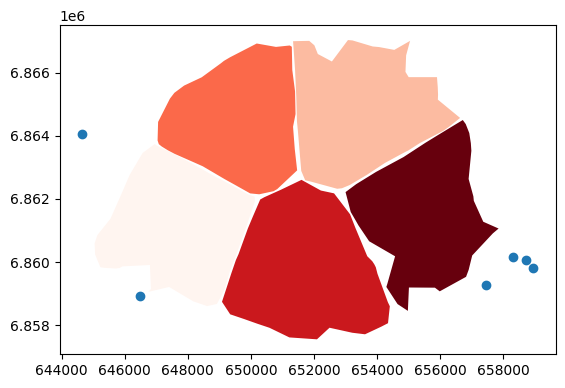

In [9]:
#compute clusters covering
list_hulls = []
if horo.cluster.min() == 0:
    for i in list_clusters:
        list_hulls.append(cg.hull_delaunay(list(i.geometry),length=2000))

else: 
    unclusters = list_clusters[0]
    for i in list_clusters[1:]:
        list_hulls.append(cg.hull_delaunay(list(i.geometry),length=1000)) 


hulls = gp.GeoDataFrame(geometry=gp.GeoSeries(list_hulls))
    
ax = hulls.plot(cmap='Reds')
if horo.cluster.min() != 0:
    unclusters.plot(ax=ax)

In [10]:
hulls = hulls.set_crs(crs='EPSG:2154') #specify the crs of the hulls
horo['nb'] = 1 #creates a column for count of points

#creating id for each hull
for i in range(len(hulls)):
    hulls.loc[i,"id_hull_1"] = i

horo_id_hull = gp.sjoin(horo, hulls) #transfer the id of hull in each overlaping points
horo_hull_agr = horo_id_hull.groupby(['id_hull_1']).sum(['nb']) #get the sum of points for each hull id
hulls_count = hulls.merge(right=horo_hull_agr, how='left', on = 'id_hull_1') #merge this sum into the hull GeoDataFrame
hulls_count = hulls_count[['geometry','id_hull_1','nb']]
hulls_count

,geometry,id_hull_1,nb
0,"POLYGON ((645932.128 6859860.26, 645840.711 68...",0.0,942
1,"POLYGON ((653224.021 6867024.259, 653863.03 68...",1.0,598
2,"POLYGON ((651401.876 6865405.702, 651416.975 6...",2.0,758
3,"POLYGON ((653216.012 6857754.777, 652494.687 6...",3.0,736
4,"POLYGON ((656992.608 6863525.113, 656905.802 6...",4.0,628


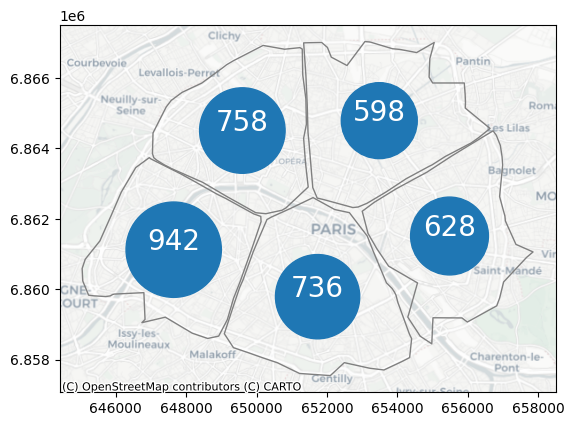

In [11]:
#Creates the map for the first zoom level

ax = hulls_count.plot(facecolor = 'None', edgecolor = "grey")
ax.scatter(x=np.asarray(hulls_count.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(hulls_count.centroid.get_coordinates())[:,-1], s=hulls_count['nb']*5)
for i, label in enumerate(hulls_count['nb']):
    plt.annotate(label, (np.asarray(hulls_count.geometry.centroid.get_coordinates())[:,:1][i], np.asarray(hulls_count.centroid.get_coordinates())[:,-1][i]), 
                         ha='center',fontsize=20, color="white")

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, crs='EPSG:2154')


In [12]:
list_horo_lvl2 = []
list_coords_lvl2 = []
for i in range(len(horo_id_hull.id_hull_1.unique())):
    list_horo_lvl2.append(horo_id_hull[(horo_id_hull.id_hull_1 == i)])

list_coords_lvl2 = []
for i in range(len(list_horo_lvl2)):
    list_coords_lvl2.append(np.vstack((list_horo_lvl2[i].geometry.x, list_horo_lvl2[i].geometry.y)).T)
 

def clstr_4(figure_size,n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42) #instanciate dbscan class, specifiying parameters
    # i.e n_clusters = the number of clusters to find in the dataset 
    # random_state = used to have always the same choices regarding the initial centroïds
    clusters = kmeans.fit_predict(list_coords_lvl2[0]) #compute the clusters
    list_horo_lvl2[0].loc[:,'cluster'] = clusters #add the id of the cluster of each point as a new column

    list_col_clus_lvl2 = []
    for i in range(len(list_horo_lvl2[0].cluster.unique())):
        list_col_clus_lvl2.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

    col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus_lvl2)

    if len(list_horo_lvl2[0].cluster.unique()) > 1:
        ax = list_horo_lvl2[0].plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
    else:
        ax =list_horo_lvl2[0].plot(color="grey", figsize=(figure_size,figure_size))

ipywidgets.interact(clstr_4, figure_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                           n_clusters = ipywidgets.IntSlider(value =5, min = 1, max = 20,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=8, continuous_update=False, description='figure_size', max=16, min=1), I…

<function __main__.clstr_4(figure_size, n_clusters)>

<Axes: >

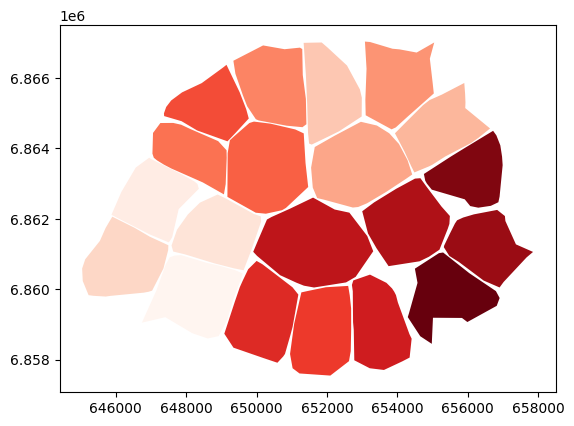

In [13]:
list_clusters_2 = []
kmeans = cluster.KMeans(n_clusters=4, random_state=42)

for i in range(len(list_coords_lvl2)):
    clusters = kmeans.fit_predict(list_coords_lvl2[i])
    list_horo_lvl2[i].loc[:,'cluster'] = clusters
    for j in range(4):
        list_clusters_2.append(list_horo_lvl2[i][(list_horo_lvl2[i].cluster == j)])

list_hulls_2 = []
for i in list_clusters_2:
    list_hulls_2.append(cg.hull_delaunay(list(i.geometry),length=1000))

hulls_2 = gp.GeoDataFrame(geometry=gp.GeoSeries(list_hulls_2))

hulls_2 = hulls_2.set_crs(crs='EPSG:2154') #specify the crs of the hulls_2

#creating id for each hull
for i in range(len(hulls_2)):
    hulls_2.loc[i,"id_hull_2"] = i

horo_id_hull_2 = gp.sjoin(horo, hulls_2) #transfer the id of hull in each overlaping points
horo_hull_agr_2 = horo_id_hull_2.groupby(['id_hull_2']).sum(['nb']) #get the sum of points for each hull id
hulls_count_2 = hulls_2.merge(right=horo_hull_agr_2, how='left', on = 'id_hull_2') #merge this sum into the hull GeoDataFrame
hulls_count_2 = hulls_count_2[['geometry','id_hull_2','nb']]

hulls_2.plot(cmap='Reds')

In [22]:
horo_clean = horo.loc[:,['numhoro','adresse','geometry']]
horo_clean.to_crs(crs='EPSG:4326', inplace=True)
hulls_count.to_crs(crs='EPSG:4326', inplace=True)
hulls_count_2.to_crs(crs='EPSG:4326', inplace=True)
unclusters.loc[:,:].to_crs(crs='EPSG:4326', inplace=True)


m = ipyleaflet.Map(center=(48.8566, 2.3522), zoom=15,min_zoom =12, max_zoom = 18, basemap=ipyleaflet.basemaps.CartoDB.Positron)

def flip(x, y):
    return y, x

def create_markers_from_gdf(gdf):
    global markers
    markers = []
    for _, row in gdf.iterrows():
        lon = gdf.loc[_,'geometry'].x
        lat = gdf.loc[_,'geometry'].y

        circle_marker = ipyleaflet.CircleMarker(location=(lat, lon), radius=5, fill_opacity=0.7)
        markers.append(circle_marker)

def create_poly_from_gdf(gdf):
    global polys
    polys = []

    for _, row in gdf.iterrows():
        row['geometry'] = transform(flip, row['geometry'])
        coords = list(row['geometry'].exterior.coords) 
        polygon = ipyleaflet.Polygon(locations=coords, color="blue", fill_color="blue", fill_opacity = 0, weight=2)
        polys.append(polygon)

def create_circle_from_gdf(gdf):
    global circle_2
    circle_2 = []

    for _, row in gdf.iterrows():
        lon = gdf.loc[_,'geometry'].centroid.x
        lat = gdf.loc[_,'geometry'].centroid.y

        circle_marker = ipyleaflet.CircleMarker(location=(lat, lon), radius=int(row['nb']*0.1), fill_opacity=0.7, weight=2)
        circle_2.append(circle_marker)

create_poly_from_gdf(hulls_count)
layer_group_2 = ipyleaflet.LayerGroup(layers=polys)
create_circle_from_gdf(hulls_count)
layer_group_2_circle = ipyleaflet.LayerGroup(layers=circle_2)


create_poly_from_gdf(hulls_count_2)
layer_group_3 = ipyleaflet.LayerGroup(layers=polys_2)
create_circle_from_gdf(hulls_count_2)
layer_group_3_circle = ipyleaflet.LayerGroup(layers=circle_3)

create_markers_from_gdf(unclusters)
uncluster_pts = ipyleaflet.LayerGroup(layers=markers_2)

create_markers_from_gdf(horo_clean)
layer_group = ipyleaflet.LayerGroup(layers=markers)
m.add_layer(layer_group)

def on_zoom_change(event):
    if m.zoom < 13:
        if len(m.layers[1].layers) != 5:
            for i in range(23):
                m.remove_layer(m.layers[1])
            m.add_layer(layer_group_2_circle)
            m.add_layer(uncluster_pts)
            for i,row in hulls_count.iterrows():
                m.add(ipyleaflet.Popup(location=[row['geometry'].centroid.y,row['geometry'].centroid.x],child=ipywidgets.HTML(value = str(row['nb'])), auto_close = False, auto_pan=False))
            m.add_layer(layer_group_2)
            
                      

    elif 12 < m.zoom < 15:
        if len(m.layers[1].layers) != 20:
            if len(m.layers) > 2:
                for i in range(8):
                    m.remove_layer(m.layers[1])
            else:
                m.remove_layer(m.layers[1])
            m.add_layer(layer_group_3_circle)
            m.add_layer(uncluster_pts)
            for i,row in hulls_count_2.iterrows():
                m.add(ipyleaflet.Popup(location=[row['geometry'].centroid.y,row['geometry'].centroid.x],child=ipywidgets.HTML(value = str(row['nb'])), auto_close = False, auto_pan=False))
            m.add_layer(layer_group_3)
            
    else:
        if len(m.layers) > 2:
            for i in range(23):
                m.remove_layer(m.layers[1])
       
            m.add_layer(layer_group)
    
m.observe(on_zoom_change, names='zoom')

display(m)

Map(center=[48.8566, 2.3522], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…